In [1]:
import tensorflow as tf
from tensorflow.python.data import Dataset
import pandas as pd
import numpy as np
% matplotlib inline

import math

from IPython import display
from matplotlib import cm, gridspec
import matplotlib.pyplot as plt

from sklearn import metrics


/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows=9
pd.options.display.float_format = '{:.1f}'.format

In [3]:
pd.__version__

'0.22.0'

In [4]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f30f8fd3e10>]],
      dtype=object)

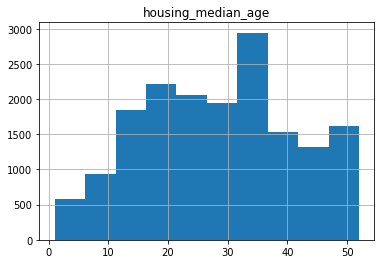

In [5]:
california_housing_dataframe.hist('housing_median_age')

In [6]:
city_names = pd.Series(['San Francisco', 'San Jose', 'Sacramento'])
population = pd.Series([852469, 1015785, 485199])

pd.DataFrame({ 'City name': city_names, 'Population': population })
cities = pd.DataFrame({ 'City name': city_names, 'Population': population })

In [7]:
cities['Area square miles'] = pd.Series([46.87, 176.53, 97.92])
cities['Population density'] = cities['Population'] / cities['Area square miles']

In [8]:
cities['ble'] = cities.apply(lambda x: x['City name'].startswith('San') & (x['Area square miles']>50), axis=1)

In [9]:
cities

,City name,Population,Area square miles,Population density,ble
0,San Francisco,852469,46.9,18187.9,False
1,San Jose,1015785,176.5,5754.2,True
2,Sacramento,485199,97.9,4955.1,False


In [10]:
cities.reindex([3,6,5])

,City name,Population,Area square miles,Population density,ble
3,NaN,nan,nan,nan,NaN
6,NaN,nan,nan,nan,NaN
5,NaN,nan,nan,nan,NaN


In [11]:
cities

,City name,Population,Area square miles,Population density,ble
0,San Francisco,852469,46.9,18187.9,False
1,San Jose,1015785,176.5,5754.2,True
2,Sacramento,485199,97.9,4955.1,False


In [12]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

In [13]:
california_housing_dataframe['median_house_value'] /= 1000

In [14]:
my_feature = california_housing_dataframe[["total_rooms"]]

In [15]:
feature_columns = [tf.feature_column.numeric_column('total_rooms')]

In [16]:
targets = california_housing_dataframe['median_house_value']

In [164]:
optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.00001)
optimiser = tf.contrib.estimator.clip_gradients_by_norm(optimiser, 5.0)

In [165]:
linRegressor = tf.estimator.LinearRegressor(feature_columns=feature_columns, optimizer=optimiser, model_dir='data/model_dir')

In [166]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
      """
    
    features = {key: np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels
        
    

In [167]:
_ = linRegressor.train(
    input_fn=lambda: my_input_fn(my_feature, targets),
    steps=100)

In [168]:
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

In [169]:
predictions = linRegressor.predict(input_fn=prediction_input_fn)

In [170]:
predictions = [item['predictions'][0] for item in predictions]

In [171]:
mse = metrics.mean_squared_error(targets, predictions)

In [172]:
rmse = math.sqrt(mse)

In [173]:
rmse

225.5103190135566

In [111]:
california_housing_dataframe['median_house_value'].max()-california_housing_dataframe['median_house_value'].min()

485.00199999999995

In [112]:
calibration_data = pd.DataFrame()
calibration_data['target'] = pd.Series(targets)
calibration_data['predictions'] = pd.Series(predictions)
calibration_data.describe()

,target,predictions
count,17000.0,17000.0
mean,207.3,120.0
std,116.0,98.9
min,15.0,0.1
25%,119.4,66.3
50%,180.4,96.5
75%,265.0,143.0
max,500.0,1721.6


In [113]:
sample = california_housing_dataframe.sample(n=300)

In [114]:
tf.train.list_variables('model_dir/')

[('global_step', []),
 ('linear/linear_model/bias_weights', [1]),
 ('linear/linear_model/total_rooms/weights', [1, 1])]

In [115]:
weight = linRegressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]

In [116]:
bias = linRegressor.get_variable_value('linear/linear_model/bias_weights')

In [117]:
x_0 = sample['total_rooms'].min()
x_1 = sample['total_rooms'].max()

In [118]:
y_0 = bias + x_0*weight
y_1 = bias + x_1*weight

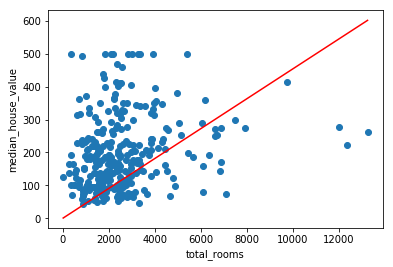

In [119]:
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")
plt.scatter(sample['total_rooms'], sample['median_house_value'])
plt.plot([x_0, x_1], [y_0, y_1], c='r');

In [154]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
  period 00 : 178.93
  period 01 : 179.55
  period 02 : 181.36
  period 03 : 178.75
  period 04 : 178.55
  period 05 : 178.54
  period 06 : 178.48
  period 07 : 179.02
  period 08 : 177.49
  period 09 : 176.39
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,176.2,207.3
std,145.3,116.0
min,0.2,15.0
25%,97.5,119.4
50%,141.8,180.4
75%,210.1,265.0
max,2528.6,500.0


Final RMSE (on training data): 176.39


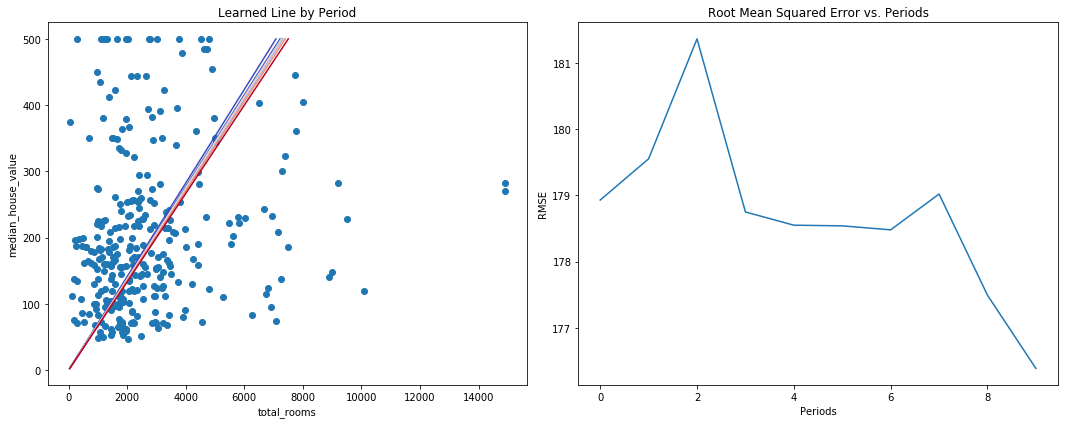

In [153]:
train_model(0.00002, 500, 5)